In [1]:
# Initialize notebook: imports and plot style config
%run init.py

Current time: 2020-04-03 13:06:35.390702


In [79]:
# source and format dataset
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url)

# rename columns
data = data.rename(columns={
    'Date': 'date',
    'Country/Region': 'location',
    'Province/State': 'region',
    'Confirmed': 'cases',
    'Recovered': 'recovered',
    'Deaths': 'deaths',
})

# dates to datetime
data['date'] = data['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%d'))

# format region naming
def format_region(row):
    if row['region'] is np.nan:
        return row['location']
    else:
        return row['region']
data['region'] = data.apply(format_region, axis=1)

# dictionary of population
population = {
    'Hubei': 56e6,
    'Korea, South': 54.5e6,
    'Japan': 127e6,
    'Iran': 81e6,
    'Australia': 24.6e6,
    'US': 327e6,
    'Switzerland': 8.5e6,
    'Austria': 8.8e6,
    'Germany': 82.7e6,
    'France': 67e6,
    'United Kingdom': 66.5e6,
    'Spain': 46.6e6,
    'San Marino': 33.7e3,
    'Italy': 60e6,
}
for state in population.keys():
    data.at[data.region==state, 'population'] = population[state]
data['population'] = data['population'].replace(np.nan, 9999999999)
data = data.replace(np.nan,0.0000000001)

# add differential columns
for col in ['cases', 'recovered', 'deaths']:
    data['new_'+col] = data[col].diff()
    
# add missing overall data for country
for country in data[data.region!=data.location].location.unique():
    if (country in data[data.location==country].region.unique())==False:
        df = data[data.location==country].groupby(['location', 'date'],as_index=False).sum()
        df['region'] = country
        data = data.append(df, ignore_index=True)
        
# relative increment (averaged over 1, 2, 3, 4 days)
for var in ['cases', 'deaths', 'recovered']: 
    for dayspan in [1,2,3,4]:
        colname = var+'_delta'+str(dayspan)
        data[colname] = 0
        for i in np.arange(dayspan):
            data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
        data[colname] = data[colname]/dayspan
        data[colname] = data[colname].map('{:.1e}'.format)

# add date per 100k inhabitants
for var in ['cases','new_cases','deaths','new_deaths','recovered','new_recovered']:
    data[var+'_per100k'] = data.apply(lambda row: row[var]/row.population*1e5, axis = 1)
    
# ordering and casting/formatting columns   
data = data[['date','region','cases','new_cases','deaths','new_deaths','recovered','new_recovered','population',
             'cases_per100k','new_cases_per100k','deaths_per100k','new_deaths_per100k','recovered_per100k','new_recovered_per100k',
             'cases_delta1','cases_delta2','cases_delta3','cases_delta4',
             'deaths_delta1','deaths_delta2','deaths_delta3','deaths_delta4',
             'recovered_delta1','recovered_delta2','recovered_delta3','recovered_delta4',
            ]]
data = data.replace(np.nan,0.0000000001)
data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population']] = data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population']].astype(int)

# last update time
lastday = pd.to_datetime(str(data.date.unique()[-1]))
print('\n Last updated data on:', lastday)

# print available countries
#print('\n Available Countries', data.region.unique())

data[data.date==lastday].sort_values('cases_per100k', ascending=False).head(15)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)



 Last updated data on: 2020-04-02 00:00:00


,date,region,cases,new_cases,deaths,new_deaths,recovered,new_recovered,population,cases_per100k,new_cases_per100k,deaths_per100k,new_deaths_per100k,recovered_per100k,new_recovered_per100k,cases_delta1,cases_delta2,cases_delta3,cases_delta4,deaths_delta1,deaths_delta2,deaths_delta3,deaths_delta4,recovered_delta1,recovered_delta2,recovered_delta3,recovered_delta4
15263,2020-04-02,San Marino,245,9,30,4,21,8,33700,727.0,26.7,89.0,11.9,62.3,23.7,3.8e-02,1.9e-02,2.1e-02,2.3e-02,1.5e-01,7.7e-02,6.5e-02,8.3e-02,6.2e-01,3.1e-01,2.1e-01,4.5e-01
16055,2020-04-02,Spain,112065,7947,10348,961,26743,4096,46600000,240.5,17.1,22.2,2.1,57.4,8.8,7.6e-02,8.1e-02,8.4e-02,8.8e-02,1.0e-01,1.1e-01,1.0e-01,1.1e-01,1.8e-01,1.8e-01,1.7e-01,1.6e-01
16415,2020-04-02,Switzerland,18827,1059,536,48,4013,1046,8500000,221.5,12.5,6.3,0.6,47.2,12.3,6.0e-02,6.5e-02,5.8e-02,6.2e-02,9.8e-02,1.1e-01,1.4e-01,1.6e-01,3.5e-01,4.9e-01,3.3e-01,2.8e-01
10727,2020-04-02,Italy,115242,4668,13915,760,18278,1431,60000000,192.1,7.8,23.2,1.3,30.5,2.4,4.2e-02,4.4e-02,4.2e-02,4.2e-02,5.8e-02,5.8e-02,6.3e-02,6.6e-02,8.5e-02,7.8e-02,7.7e-02,8.8e-02
1223,2020-04-02,Austria,11129,418,158,12,1749,313,8800000,126.5,4.8,1.8,0.1,19.9,3.6,3.9e-02,4.6e-02,5.0e-02,6.1e-02,8.2e-02,1.1e-01,1.4e-01,1.7e-01,2.2e-01,2.6e-01,4.2e-01,3.9e-01
5111,2020-04-02,Hubei,67802,0,3199,6,63471,145,56000000,121.1,0.0,5.7,0.0,113.3,0.3,0.0e+00,7.4e-06,4.9e-06,3.7e-06,1.9e-03,1.9e-03,1.4e-03,1.3e-03,2.3e-03,2.5e-03,3.1e-03,3.6e-03
9359,2020-04-02,Germany,84794,6922,1107,187,22440,3740,82700000,102.5,8.4,1.3,0.2,27.1,4.5,8.9e-02,8.7e-02,8.2e-02,8.1e-02,2.0e-01,2.0e-01,2.0e-01,2.0e-01,2.0e-01,1.8e-01,1.8e-01,2.5e-01
8423,2020-04-02,France,59105,2116,5387,1355,12428,1494,67000000,88.2,3.2,8.0,2.0,18.5,2.2,3.7e-02,6.5e-02,1.0e-01,1.0e-01,3.4e-01,2.4e-01,2.2e-01,2.0e-01,1.4e-01,1.5e-01,1.6e-01,1.5e-01
17135,2020-04-02,US,243453,30081,5926,1169,9001,527,327000000,74.5,9.2,1.8,0.4,2.8,0.2,1.4e-01,1.4e-01,1.5e-01,1.5e-01,2.5e-01,2.4e-01,2.6e-01,2.5e-01,6.2e-02,1.3e-01,1.7e-01,4.1e-01
10439,2020-04-02,Iran,50468,2875,3160,124,16711,1238,81000000,62.3,3.5,3.9,0.2,20.6,1.5,6.0e-02,6.4e-02,6.7e-02,7.1e-02,4.1e-02,4.4e-02,4.7e-02,4.6e-02,8.0e-02,6.8e-02,6.3e-02,7.8e-02


In [3]:
# dictionary of lockdown dates
lockdown = {
    'Italy': datetime.date(2020,3,11),
    'Hubei': datetime.date(2020,1,25),
    'Iran': datetime.date(2020,3,15),
    'Spain': datetime.date(2020,3,14),
    'United Kingdom': datetime.date(2020,3,25),
    'Austria': datetime.date(2020,3,16),
}

# dictionary of colors
color = {
    'Hubei': 'r',
    'Korea, South': 'purple',
    'Japan': 'grey',
    'Iran': 'limegreen',
    'Australia': 'royalblue',
    'US': 'hotpink',
    'Switzerland': 'brown',
    'Austria': 'pink',
    'Germany': 'black',
    'France': 'blue',
    'United Kingdom': 'g',
    'Spain': 'orange',
    'San Marino': 'paleturquoise',
    'Italy': 'dodgerblue',
}

In [4]:
# Utility functions

def rate(df, var, dayspan=3):
    k=[]
    for i in np.arange(dayspan):
        k.append(df['new_'+var].iat[-1-i]/df[var].iat[-1-i])
    return np.mean(k)*100

def format_dateaxis():
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()

def lockdown_lines():
    for state in lockdown.keys():
        ax.vlines(lockdown[state],-1000,1000, color=color[state], linestyle='--', linewidth=2, alpha=0.75)

def sorted_states(states, var):
    df = data[data.region.isin(states)][data.date==lastday].sort_values(var, ascending=False)
    states = df.region.unique()
    return states

def leglabels_style():
    leg._legend_box.align = "left"
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())

def plot_total(var,lw=3):
    for state in states:
        df = data[data.region==state]
        pop = population[state]
        tot = df[var].iat[-1] # total value at current date
        new = df['new_'+var].iat[-1]
        k = rate(df, var)
        label = state + '\nTotal: %.f (+%.f)\n1 over %.f\nDaily increase: +%.1f%s' % (tot, new, pop/tot, k, '%')
        if var=='deaths': 
            mortality = tot/df['cases'].iat[-1]*100
            label = label + '\nMortality: %.1f%s' % (mortality, '%')
        ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=lw)

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


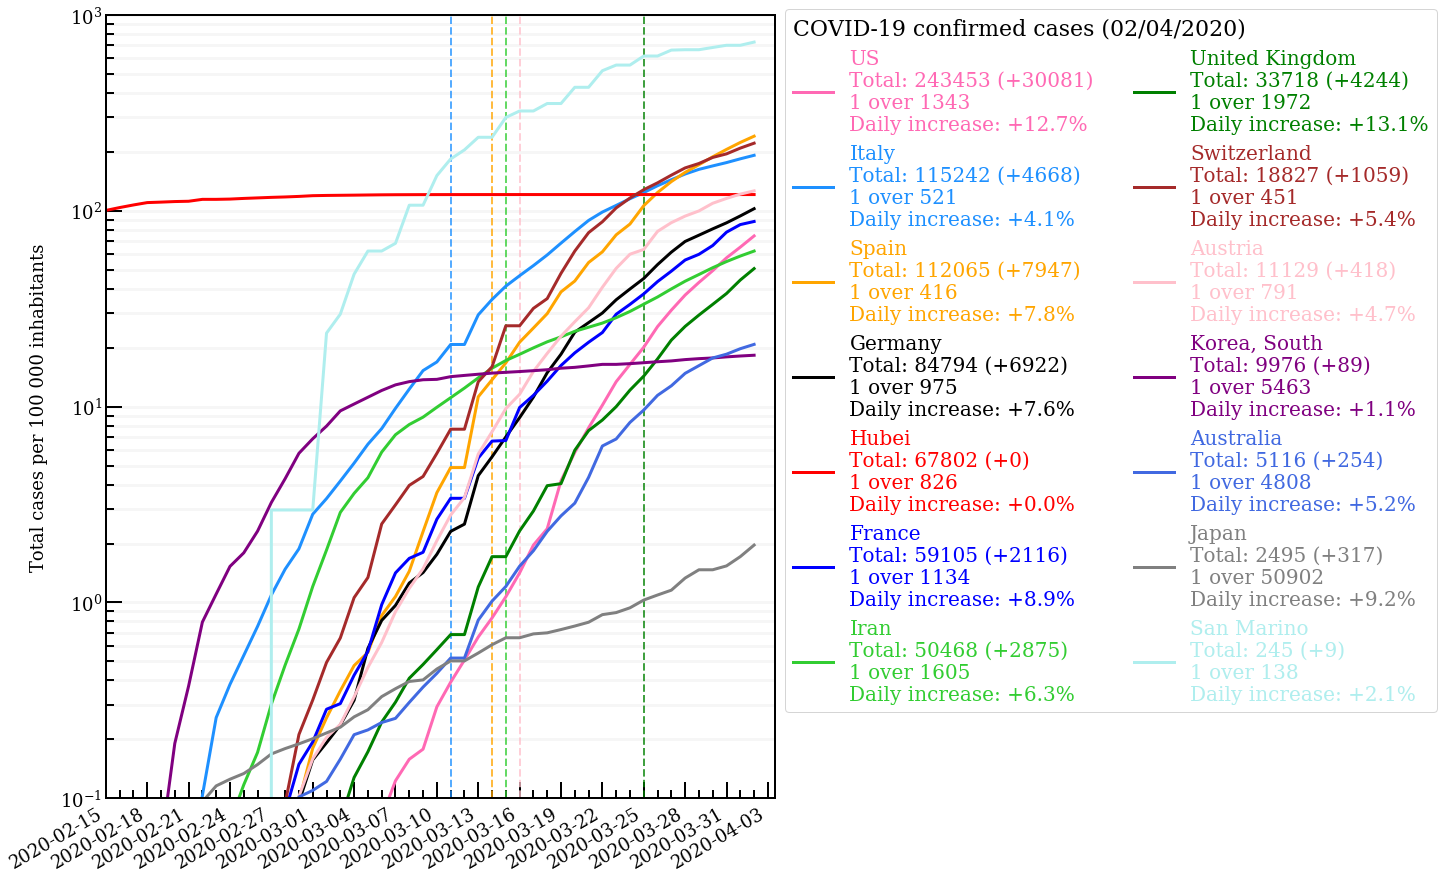

In [5]:
var = 'cases' # selected variable
states = population.keys() # selected states

fig = plt.figure(figsize=(12,16))
ax = fig.add_subplot(111)

#lockdown lines
lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
plot_total(var)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 2, 15), today+timedelta(days=0)])
ax.set_ylim(1e-1,1e3)
plt.ylabel('Total ' + var + ' per 100 000 inhabitants')
plt.yscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc='upper left', ncol=2, fontsize=20, title_fontsize=22, bbox_to_anchor=(1,1.02), title='COVID-19 confirmed cases (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


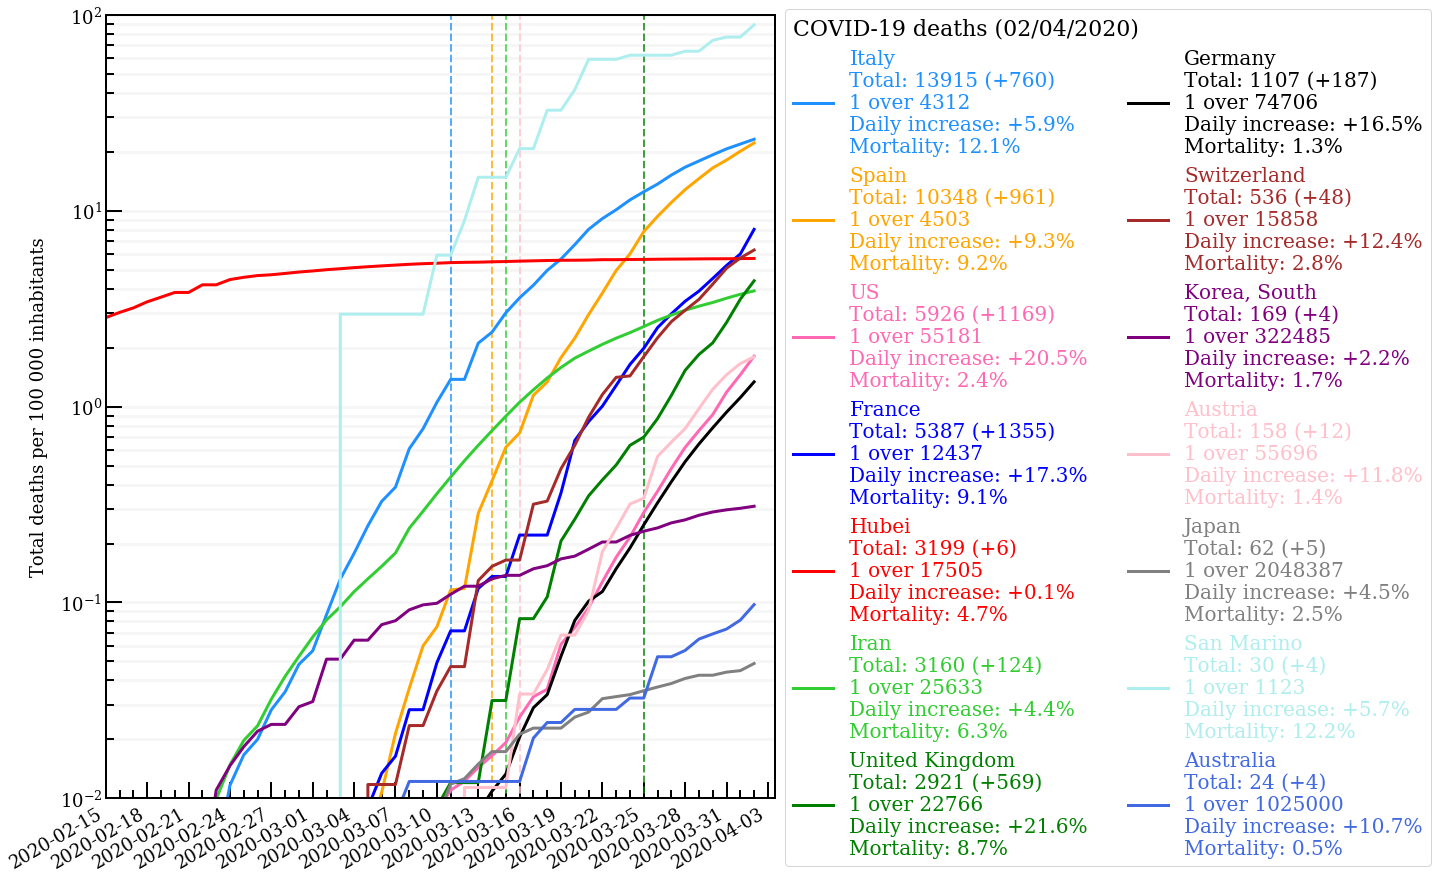

In [6]:
var = 'deaths'

fig = plt.figure(figsize=(12,16))
ax = fig.add_subplot(111)

#lockdown lines
lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
plot_total(var)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 2, 15), today+timedelta(days=0)])
ax.set_ylim(1e-2,1e2)
plt.ylabel('Total ' + var + ' per 100 000 inhabitants')
plt.yscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc='upper left', ncol=2, fontsize=20, title_fontsize=22, bbox_to_anchor=(1,1.02), title='COVID-19 deaths (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


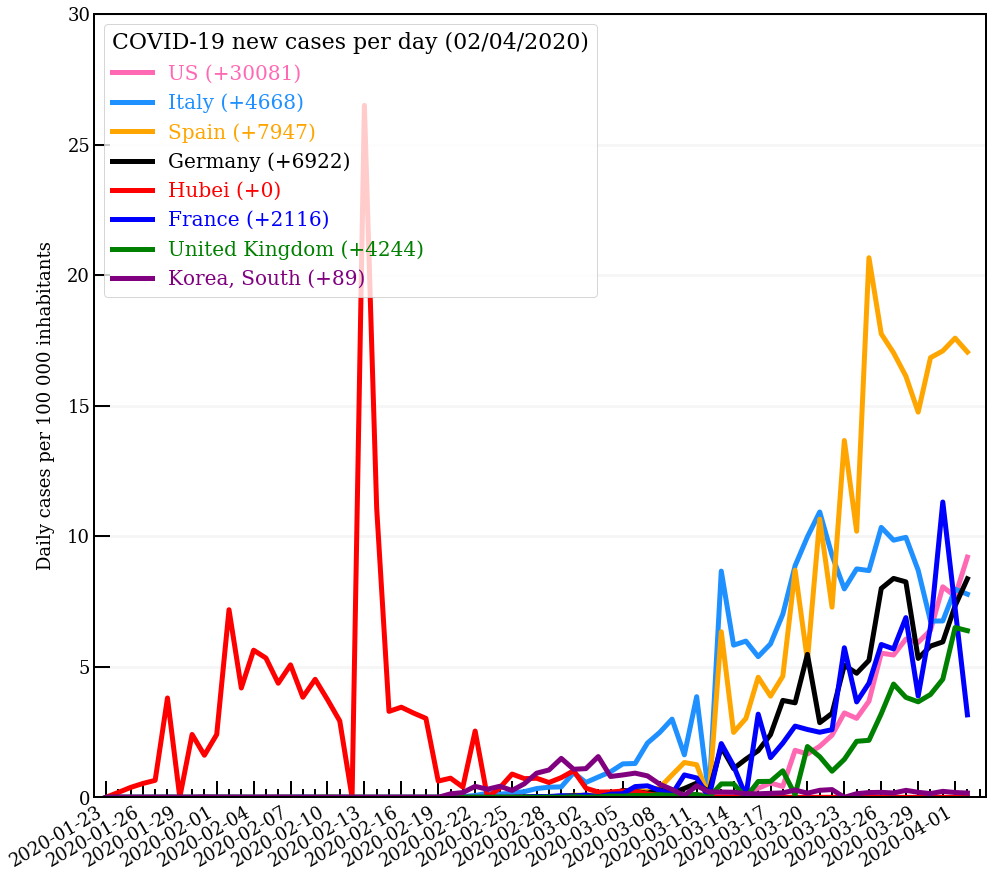

In [7]:
var = 'new_cases'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, 'cases')

# plot curves
for state in states:
    df = data[data.region==state]
    pop = population[state]
    tot = df[var].iat[-1] # total value at current date
    label = state + ' (+%.f)' % tot
    ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=5)

# axes
format_dateaxis()
ax.set_xlim([datetime.datetime(2020, 1, 22), today+timedelta(days=0)])
ax.set_ylim(0,30)
plt.ylabel('Daily cases per 100 000 inhabitants')
#plt.yscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc='upper left', frameon=True, ncol=1, fontsize=20, title_fontsize=22, 
                 title='COVID-19 new cases per day (%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


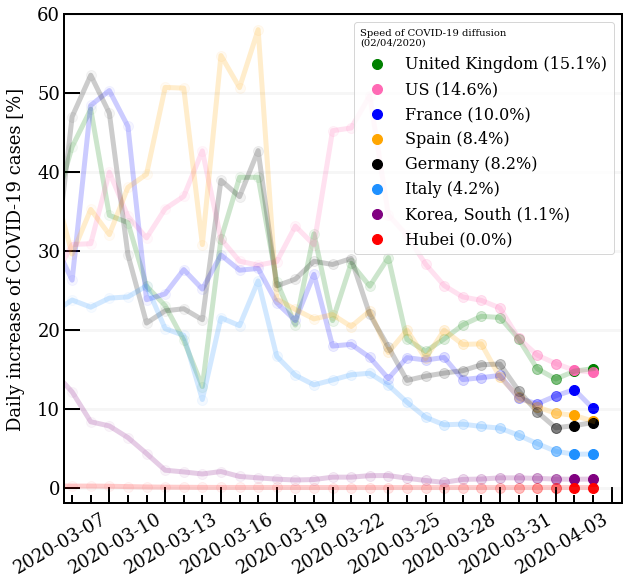

In [8]:
var = 'cases_delta3'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
for state in states:
    df = data[data.region==state]    
    ax.plot(df.date, df[var]*100, label='', color=color[state], lw=5, alpha=0.2)

ndays = 30
days = np.arange(1,ndays) 
mk='o'
ms=100
for state in states:
    df = data[data.region==state]
    tot = df[var].iat[-1]*100 # total value at current date
    pop = population[state]
    label = state + ' (%.1f%s)' % (tot,'%')
    ax.scatter(df.date.iat[-1], df[var].iat[-1]*100, label=label, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df['date'].iat[-1-day] # total value 'day' ago
        y = df[var].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
format_dateaxis()
ax.set_xlim([today-timedelta(days=ndays), today+timedelta(days=0)])
ax.set_ylim(-2,60)
plt.ylabel('Daily increase of COVID-19 cases [%]')
#plt.xscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True, ncol=1,
                 title='Speed of COVID-19 diffusion\n(%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


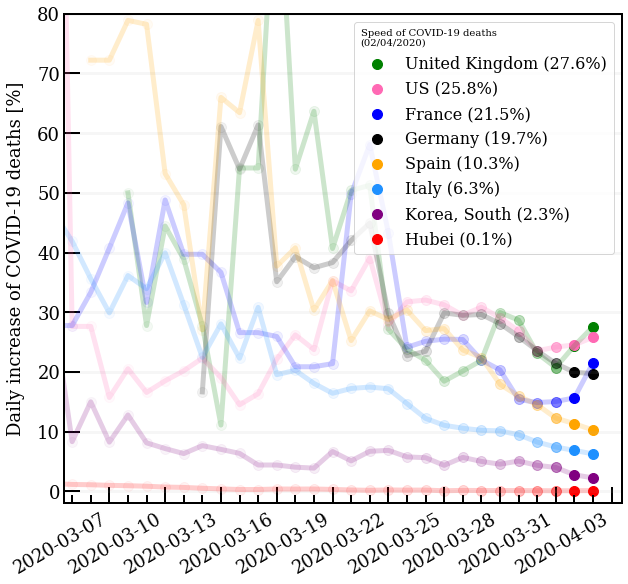

In [9]:
var = 'deaths_delta3'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
for state in states:
    df = data[data.region==state]    
    ax.plot(df.date, df[var]*100, label='', color=color[state], lw=5, alpha=0.2)

ndays = 30
days = np.arange(1,ndays) 
mk='o'
ms=100
for state in states:
    df = data[data.region==state]
    tot = df[var].iat[-1]*100 # total value at current date
    pop = population[state]
    label = state + ' (%.1f%s)' % (tot,'%')
    ax.scatter(df.date.iat[-1], df[var].iat[-1]*100, label=label, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df['date'].iat[-1-day] # total value 'day' ago
        y = df[var].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
format_dateaxis()
ax.set_xlim([today-timedelta(days=ndays), today+timedelta(days=0)])
ax.set_ylim(-2,80)
plt.ylabel('Daily increase of COVID-19 deaths [%]')
#plt.xscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True, ncol=1, 
                 title='Speed of COVID-19 deaths\n(%s)' % lastday.strftime('%d/%m/%Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


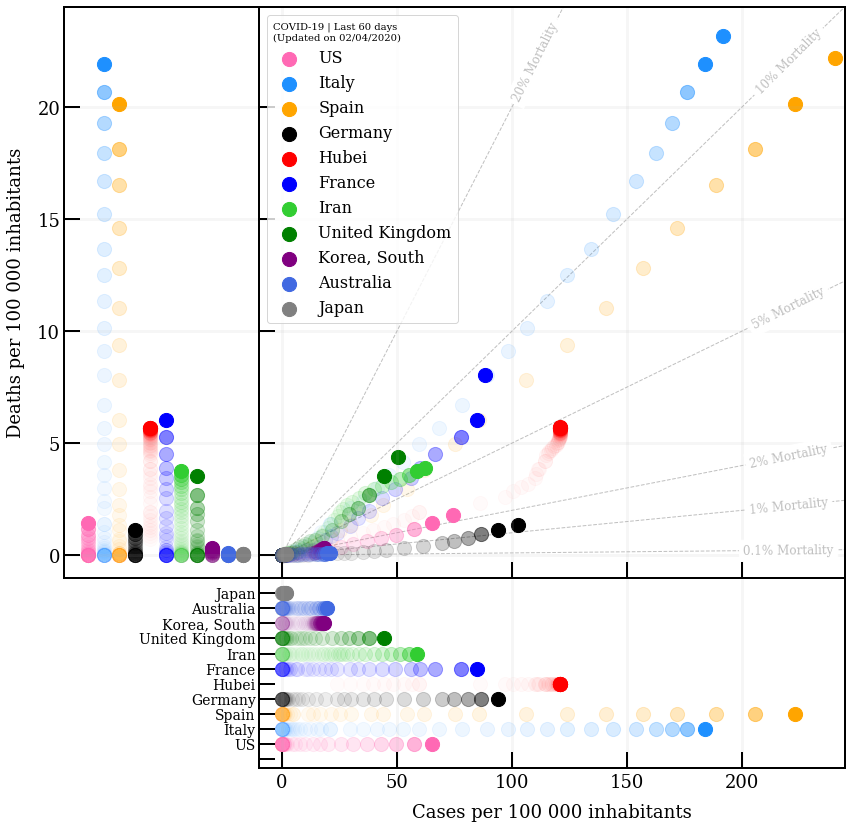

In [10]:
# Create some normally distributed data
varx = 'cases'
vary = 'deaths'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South', 'Japan', 'Australia', 'Iran']
states = sorted_states(states, 'cases')

# Set up the axes with gridspec
fig = plt.figure(figsize=(14,14))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
ax = fig.add_subplot(grid[:-1, 1:])
y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
x_ax.tick_params(axis='y', which='major', labelsize=14)

# axes
xmax = 245
yratio = 0.1
ax.set_ylim(-10*yratio,xmax*yratio)
ax.set_xlim(-10,xmax)
y_ax.set_ylabel('Deaths per 100 000 inhabitants')
x_ax.set_xlabel('Cases per 100 000 inhabitants')

# mortality guidelines
color_guide = 'silver'
m = 2.
ax.plot((0,10*xmax), (0,10*yratio*m*xmax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*yratio*xmax, '20% Mortality', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w')
m = 1.
ax.plot((0,10*xmax), (0,10*yratio*m*xmax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*yratio*xmax, '10% Mortality', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w')
m = 0.2
ax.plot((0,10*xmax), (0,10*yratio*m*xmax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*yratio*m*xmax, '2% Mortality', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w')
m = 0.5
ax.plot((0,10*xmax), (0,10*yratio*m*xmax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*yratio*m*xmax, '5% Mortality', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w')
m = 0.1
ax.plot((0,10*xmax), (0,10*yratio*m*xmax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*yratio*m*xmax, '1% Mortality', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w')
m = 0.01
ax.plot((0,10*xmax), (0,10*yratio*m*xmax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*yratio*m*xmax, '0.1% Mortality', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w')


# plot curves
ndays = 60
days = np.arange(1,ndays)
mk = 'o'
ms=200

#dummy points
x_ax.scatter(0,'',label='', color='w', marker=mk, s=ms, alpha=alpha)
y_ax.scatter('',0,label='', color='w', marker=mk, s=ms, alpha=alpha)

for i,state in enumerate(states):
    df = data[data.region==state]
    pop = population[state]
    ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label=state, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df[varx].iat[-1-day]/pop*1e5 # total value 'day' ago
        y = df[vary].iat[-1-day]/pop*1e5
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

        x_ax.scatter(x,state,label='', color=color[state], marker=mk, s=ms, alpha=alpha)
        y_ax.scatter(state,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)
        


ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
x_ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')
y_ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = ax.legend(loc='upper left', frameon=True, ncol=1, 
                 title='COVID-19 | Last %d days\n(Updated on %s)' % (ndays, lastday.strftime('%d/%m/%Y')))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


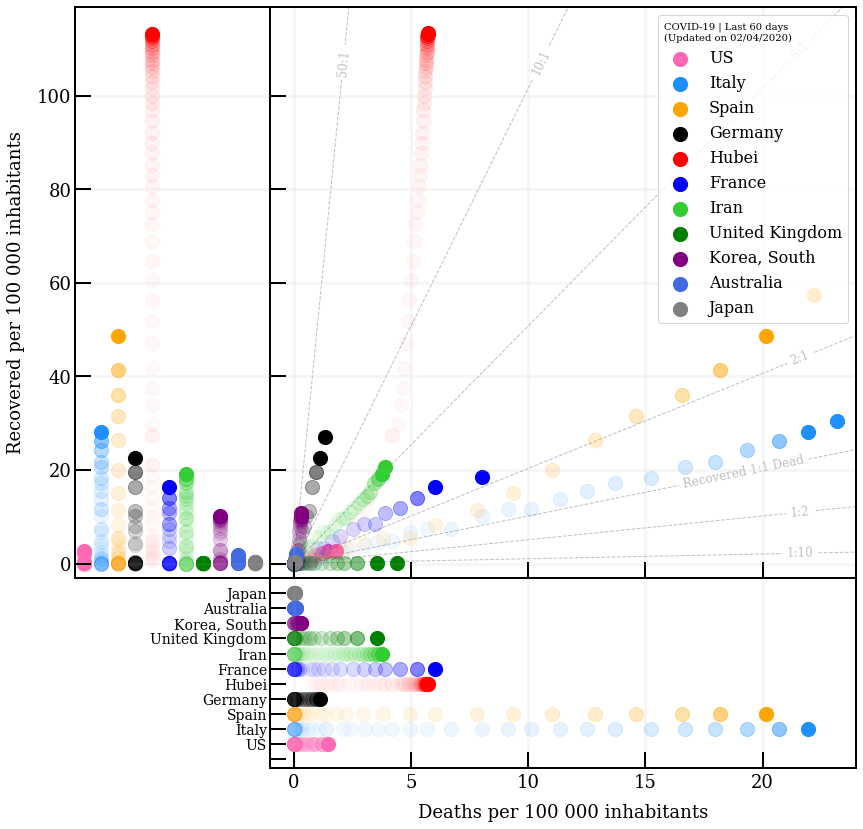

In [11]:
varx = 'deaths'
vary = 'recovered'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South', 'Japan', 'Australia', 'Iran']
#states = population.keys()
# sort by most cases
states = sorted_states(states, 'cases')

fig = plt.figure(figsize=(14,14))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
ax = fig.add_subplot(grid[:-1, 1:])
y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
x_ax.tick_params(axis='y', which='major', labelsize=14)

# axes
xmin = -1
xmax = 24
ymin = -3
ymax = 119
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
y_ax.set_ylabel('Recovered per 100 000 inhabitants')
x_ax.set_xlabel('Deaths per 100 000 inhabitants')

# mortality guidelines
color_guide='silver'
m = 50 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*ymax, '50:1', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 10 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*ymax, '10:1', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 1 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.8*xmax, 0.8*m*ymax, 'Recovered 1:1 Dead', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 2 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '2:1', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 5 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '5:1', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.5 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '1:2', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.1 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '1:10', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)


# plot curves
ndays = 60
days = np.arange(1,ndays)
mk = 'o'
ms=200

#dummy points
x_ax.scatter(0,'',label='', color='w', marker=mk, s=ms, alpha=alpha)
y_ax.scatter('',0,label='', color='w', marker=mk, s=ms, alpha=alpha)

for i,state in enumerate(states):
    df = data[data.region==state]
    pop = population[state]
    ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label=state, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df[varx].iat[-1-day]/pop*1e5 # total value 'day' ago
        y = df[vary].iat[-1-day]/pop*1e5
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

        x_ax.scatter(x,state,label='', color=color[state], marker=mk, s=ms, alpha=alpha)
        y_ax.scatter(i,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)
        
ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
x_ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')
y_ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = ax.legend(loc=0, frameon=True, ncol=1, 
                 title='COVID-19 | Last %d days\n(Updated on %s)' % (ndays, lastday.strftime('%d/%m/%Y')))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


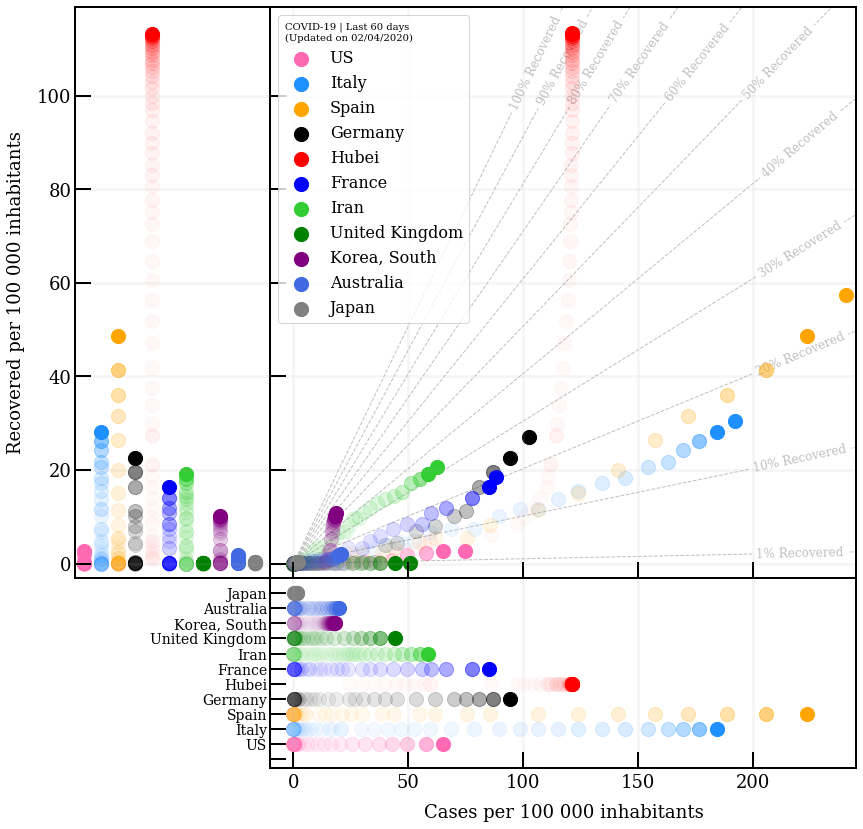

In [12]:
varx = 'cases'
vary = 'recovered'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South', 'Japan', 'Australia', 'Iran']
#states = population.keys()
# sort by most cases
states = sorted_states(states, 'cases')

fig = plt.figure(figsize=(14,14))
grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
ax = fig.add_subplot(grid[:-1, 1:])
y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
x_ax.tick_params(axis='y', which='major', labelsize=14)

# axes
xmin = -10
xmax = 245
ymin = -3
ymax = 119
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
y_ax.set_ylabel('Recovered per 100 000 inhabitants')
x_ax.set_xlabel('Cases per 100 000 inhabitants')

# mortality guidelines
color_guide='silver'
m = 1 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*ymax, '100% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.8 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*ymax, '80% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.9 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*ymax, '90% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)

m = 0.7 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*ymax, '70% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.6 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*ymax, '60% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)

m = 0.5 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax/m, 0.9*ymax, '50% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.4 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '40% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.3 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '30% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.2 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '20% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)

m = 0.1 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '10% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)
m = 0.01 * (xmax-xmin)/(ymax-ymin)
ax.plot((0,10*xmax), (0,10*m*ymax), ls='--', lw=1, color=color_guide, zorder=-100)
ax.text(0.9*xmax, 0.9*ymax*m, '1% Recovered', color=color_guide, fontsize=12, rotation=np.rad2deg(np.arctan(m)), ha='center', va='center', backgroundcolor='w', zorder=-100)


# plot curves
ndays = 60
days = np.arange(1,ndays)
mk = 'o'
ms=200

#dummy points
x_ax.scatter(0,'',label='', color='w', marker=mk, s=ms, alpha=alpha)
y_ax.scatter('',0,label='', color='w', marker=mk, s=ms, alpha=alpha)

for i,state in enumerate(states):
    df = data[data.region==state]
    pop = population[state]
    ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label=state, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df[varx].iat[-1-day]/pop*1e5 # total value 'day' ago
        y = df[vary].iat[-1-day]/pop*1e5
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

        x_ax.scatter(x,state,label='', color=color[state], marker=mk, s=ms, alpha=alpha)
        y_ax.scatter(i,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)
        
ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
x_ax.grid(axis='x', linewidth=3, alpha=0.1, which='both')
ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')
y_ax.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = ax.legend(loc=0, frameon=True, ncol=1, 
                 title='COVID-19 | Last %d days\n(Updated on %s)' % (ndays, lastday.strftime('%d/%m/%Y')))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


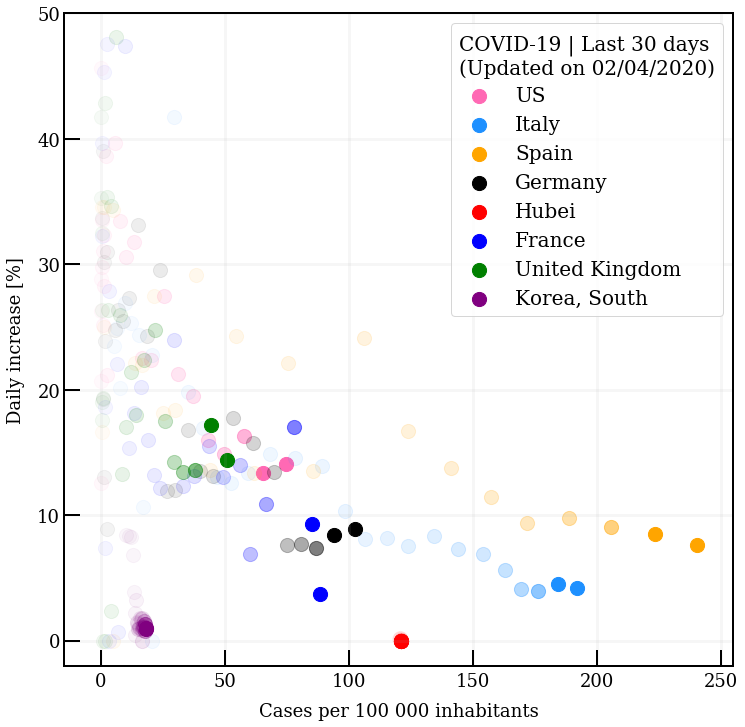

In [13]:
varx = 'cases'
vary = 'cases_delta1'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
#states = population.keys()
# sort by most cases
states = sorted_states(states, 'cases')

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# plot curves
ndays = 30
days = np.arange(1,ndays)
mk = 'o'
ms=200
for state in states:
    df = data[data.region==state]
    pop = population[state]
    ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]*100, label=state, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df[varx].iat[-1-day]/pop*1e5 # total value 'day' ago
        y = df[vary].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
xmax = 220
ax.set_ylim(-2,50)
#ax.set_xlim(-10,xmax)

plt.ylabel('Daily increase [%]')
plt.xlabel('Cases per 100 000 inhabitants')
plt.grid(axis='x', linewidth=3, alpha=0.1, which='both')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True, ncol=1, fontsize=20, title_fontsize=20, 
                 title='COVID-19 | Last %d days\n(Updated on %s)' % (ndays, lastday.strftime('%d/%m/%Y')))
leglabels_style()

plt.show()